In [1]:
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import gold_new

sns.set(font_scale=0.6)

In [2]:
from IPython.display import Image

def print_png(file, width, height, scale=30):
    return Image(file, width=width*scale, height=height*scale)

In [5]:
class Input:
    def __init__(self, log_file: str = 'right.txt'):
        importlib.reload(gold_new)
        self.frame = 0
        self.log_file = log_file
        self.cache = self.get_cache()

    def next_frame(self, frame):
        if frame is not None:
            self.frame = frame
        elif self.frame < len(self.cache):
            self.frame += 1
        else:
            self.frame = 1

    @property
    def max_frame(self):
        return len(self.cache)

    def my_matter(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['my_matter']

    def op_matter(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['op_matter']

    def input_array(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['input_array']
    
    def board(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['board']
    
    def all(self, frame=None):
        self.next_frame(frame)
        return (
            self.frame,
            self.cache[self.frame]['my_matter'],
            self.cache[self.frame]['op_matter'],
            self.cache[self.frame]['input_array'],
            self.cache[self.frame]['board'],
        )

    def get_cache(self):
        io = gold_new.InputOutput(self.log_file)
        col, row = io.get_input()
        kernel_global = gold_new.get_kernel_global(row, col, p=(74 + (2 * (col-12))) / 100)

        cache = {}
        frame = 0

        while True:
            try:
                frame += 1
                my_matter, op_matter = io.get_input()
                input_array = np.array(io.get_input(row * col)).reshape(row, col, 7)
                cache[frame] = {
                    'my_matter': my_matter,
                    'op_matter': op_matter,
                    'input_array': input_array,
                    'board': gold_new.Board(input_array, kernel_global)
                }
            except EOFError:
                break
        return cache

# perf

In [59]:
a = gold_new
io = a.InputOutput('start_f5.txt')
col, row = io.get_input()
kernel_global = gold_new.get_filter(row, col, p=(74 + (2 * (col-12))) / 100)
my_matter, op_matter = io.get_input()
input_array = np.array(io.get_input(row * col)).reshape(row, col, 7)
board = gold_new.Board(input_array, kernel_global)

In [60]:
%timeit gold_700_2023_simplified.Board(input_array)

12.5 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Kernel Global

<AxesSubplot: >

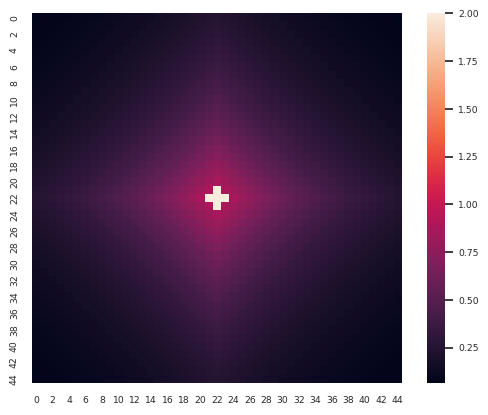

In [28]:
input = Input(log_file='start_f5.txt')
sns.heatmap(input.board(1).kernel_global, square=True)

In [29]:
def get_kernel_global(rows, cols, p):
    n = max(rows, cols) * 2 + 1
    a = np.concatenate([np.arange(n//2, 0, -1), [0.25], np.arange(1, n//2+1, 1)], axis=0)
    X, Y = np.meshgrid(a, a)
    filter = p ** (X+Y)
    filter[n//2 - 1: n//2 + 2, n//2] = 2
    filter[n//2, n//2 - 1: n//2 + 2] = 2
    return filter

get_kernel_global(5, 5, 0.95).shape

(11, 11)

<AxesSubplot: >

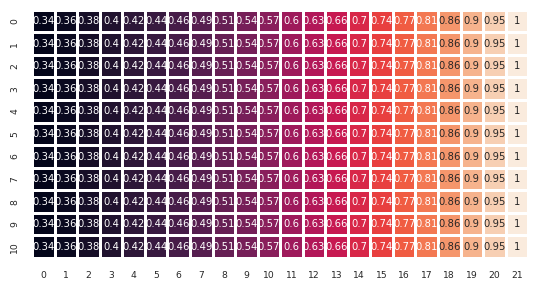

In [30]:
sns.heatmap(input.board(1).op_end_global, square=True, linewidths=1, cbar=False, annot=True)

<AxesSubplot: >

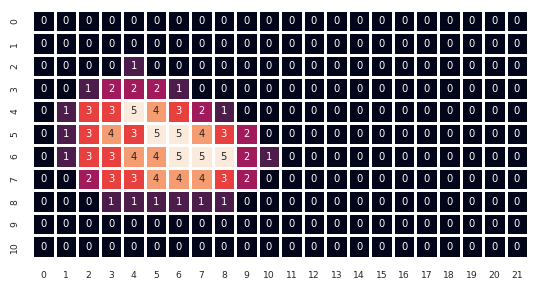

In [23]:
sns.heatmap(input.board(1).owner_op_local, square=True, linewidths=1, cbar=False, annot=True)

<AxesSubplot: >

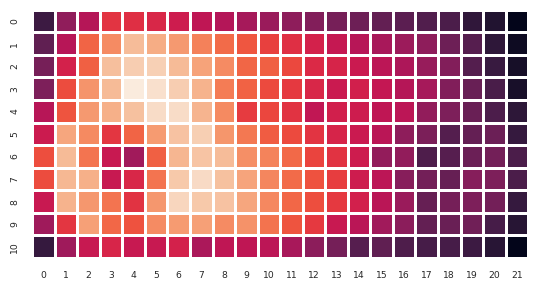

In [21]:
sns.heatmap(input.board(1).op_zones_manh_manh, square=True, linewidths=1, cbar=False)

In [164]:
def get_kernel_horizonal_gradient(rows, cols, p):
    n = max(rows, cols) * 2
    a = np.concatenate([np.arange(n)], axis=0)
    X, Y = np.meshgrid(a, a)
    filter = p ** (X)
    return filter[:rows, :cols]

np.fliplr(get_kernel_horizonal_gradient(3, 9, 0.95))

array([[0.66, 0.7 , 0.74, 0.77, 0.81, 0.86, 0.9 , 0.95, 1.  ],
       [0.66, 0.7 , 0.74, 0.77, 0.81, 0.86, 0.9 , 0.95, 1.  ],
       [0.66, 0.7 , 0.74, 0.77, 0.81, 0.86, 0.9 , 0.95, 1.  ]])

## Maps Gradents

In [126]:
input = Input(log_file='start_f5.txt')
board = input.board(1)
np.set_printoptions(edgeitems=30, linewidth=100000, precision=2)

<AxesSubplot: >

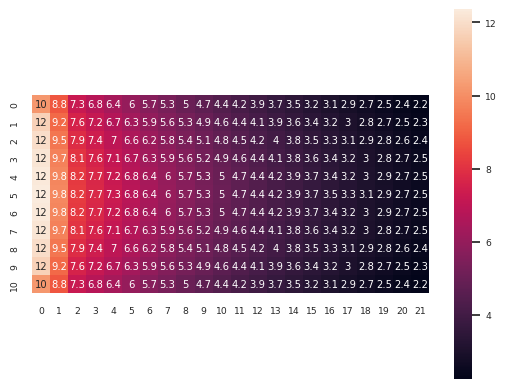

In [129]:
sns.heatmap(board.op_end_global, square=True,)

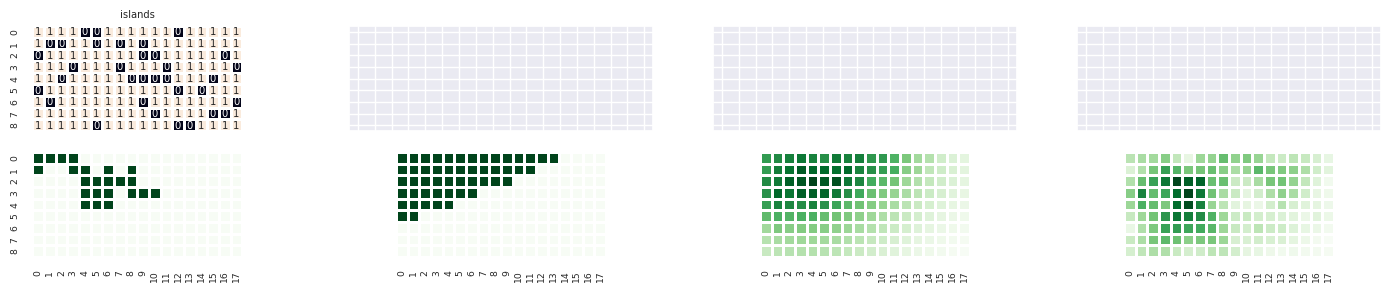

In [125]:
input = Input(log_file='offensive_spawn_1_island.txt')
board = input.board(1)
np.set_printoptions(edgeitems=30, linewidth=100000, precision=2)

fig, ax = plt.subplots(nrows=1 + len(board.island_active), ncols=4, sharex=True, sharey=True,
                       figsize=(18, len(board.island_active) * 3))

sns.heatmap(board.island, square=True, cbar=False, linewidths=1, annot=True, ax=ax[0, 0]).set_title('islands')

for row, island in enumerate(board.island_active):
    board.set_island_number(island)
    sns.heatmap(board.owner_op, square=True, cbar=False, linewidths=1, ax=ax[row+1, 0], cmap='Greens')
    sns.heatmap(board.op_zones, square=True, cbar=False, linewidths=1, ax=ax[row+1, 1], cmap='Greens')
    sns.heatmap(board.op_zones_global, square=True, cbar=False, linewidths=1, ax=ax[row+1, 2], cmap='Greens')
    sns.heatmap(board.op_zones_manh_manh, square=True, cbar=False, linewidths=1, ax=ax[row+1, 3], cmap='Greens')

### Dynamic

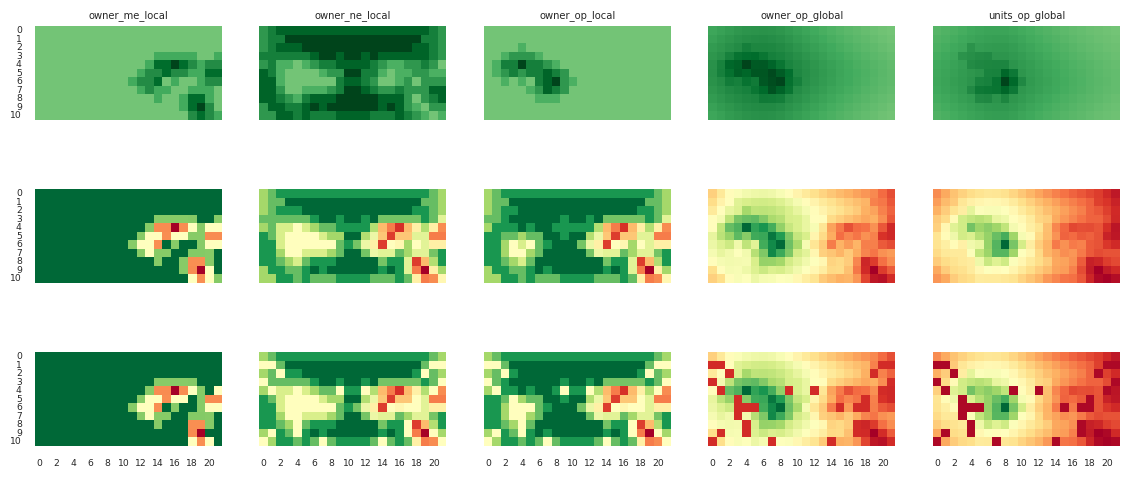

In [13]:
def show_heatmap(weights, board, condition):
    min_max = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10)
    a = np.full_like(board.scrap_amount, 0, dtype=np.float64)

    fig, ax = plt.subplots(3, len(weights), figsize=(14, 6), sharex=True, sharey=True)
    for i, (key, value) in enumerate(weights.items()):
        b = min_max(getattr(board, key))
        a += b * value
        sns.heatmap(data=b, ax=ax[0, i], square=True, cbar=False, vmin=-1, vmax=1, cmap='Greens').set_title(key)
        sns.heatmap(data=a, ax=ax[1, i], square=True, cbar=False, cmap='RdYlGn')
        sns.heatmap(data=a * condition, ax=ax[2, i], square=True, cbar=False, cmap='RdYlGn')
    plt.show()

move_weights = {
    'owner_me_local':   -1,
    'owner_ne_local':   +1,
    'owner_op_local':   +1,
    'owner_op_global':  +5,
    'units_op_global':  +5,
}
spawn_weights = {
    'owner_op_local':   +4,
    'owner_ne_local':   +1,
    'units_me_global':  -1,
}
build_weights = {
    # 'owner_me_global':  -5,
    'units_op_global':  +1,
}

input = Input(log_file='start_f5.txt')
show_heatmap(move_weights, input.board(1), input.board(1).live_active_tile)

<AxesSubplot: >

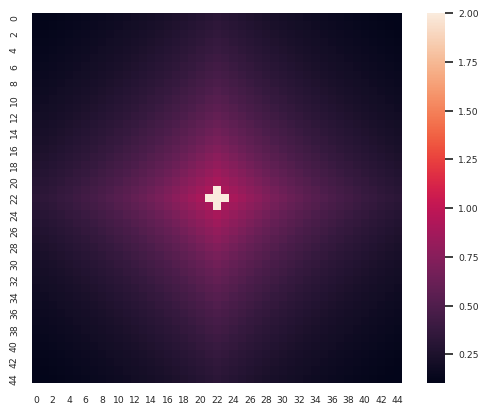

In [12]:
input = Input(log_file='start_f5.txt')
sns.heatmap(input.board(1).kernel_global, square=True)

<AxesSubplot: >

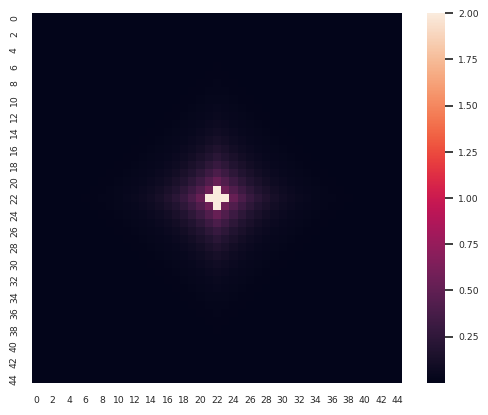

In [11]:
input = Input(log_file='start_f5.txt')
sns.heatmap(input.board(1).kernel_global, square=True)

In [ ]:
input.board(1).test

### static

In [ ]:
input = Input(log_file='start_f5.txt')

min_max = lambda x: (x - x.min()) / (x.max() - x.min())

feature = "Stacked"
default_params1 = {'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False, 'annot': True, 'fmt': ".1f"}
default_params2 = {'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False, 'vmin': -1, 'vmax': 1}
default_params3 = {'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}
frame, my_matter, op_matter, input_array, board = input.all(1)
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15, 10), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=1)

a = np.full_like(board.scrap_amount, 0, dtype=np.float64)

move_weights = {
    'owner_op_local':   +5,
    'owner_ne_local':   +3,
    'owner_me_local':   -1,
    'owner_op_global':  +10,
    'owner_ne_global':  +1,
    'units_me_global':  -5,
}

i = -1

i += 1
a += move_weights['owner_op_local']
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.owner, cmap=['#afd095','r','b'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.owner_op_local, cmap='Greens')
sns.heatmap(**default_params2, ax=ax[i, 2], data=move_weights['owner_op_local'], cmap='Greens')
sns.heatmap(**default_params3, ax=ax[i, 3], data=a, cmap='RdYlGn')
ax[i, 0].set_ylabel('owner_op_local')

i += 1
a += move_weights['owner_ne_local']
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.owner, cmap=['#afd095','r','b'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.owner_ne_local, cmap='Reds')
sns.heatmap(**default_params2, ax=ax[i, 2], data=move_weights['owner_ne_local'], cmap='Reds')
sns.heatmap(**default_params3, ax=ax[i, 3], data=a, cmap='RdYlGn')
ax[i, 0].set_ylabel('owner_ne_local')

i += 1
a += move_weights['owner_me_local']
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.owner, cmap=['#afd095','r','b'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.owner_me_local, cmap='Greens')
sns.heatmap(**default_params2, ax=ax[i, 2], data=move_weights['owner_me_local'], cmap='Greens')
sns.heatmap(**default_params3, ax=ax[i, 3], data=a, cmap='RdYlGn')
ax[i, 0].set_ylabel('owner_me_local')

i += 1
a += move_weights['owner_op_global']
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.units_op, cmap=['White', 'Green'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.owner_op_global, cmap='Greens')
sns.heatmap(**default_params2, ax=ax[i, 2], data=move_weights['owner_op_global'], cmap='Greens')
sns.heatmap(**default_params3, ax=ax[i, 3], data=a, cmap='RdYlGn')
ax[i, 0].set_ylabel('owner_op_global')

i += 1
a += move_weights['units_me_global']
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.units_me, cmap=['White', 'Red'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.units_me_global, cmap='Reds')
sns.heatmap(**default_params2, ax=ax[i, 2], data=move_weights['units_me_global'], cmap='Reds')
sns.heatmap(**default_params3, ax=ax[i, 3], data=a, cmap='RdYlGn')
ax[i, 0].set_ylabel('units_me')

# plt.suptitle(f'{feature} (in {frame=})')
for ax in ax.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## BUILD choke points

In [ ]:
from scipy.signal import convolve2d

scenario = ['spawn_spread', 'boundaries', 'p272_crash'][0]
params = {'square': True, 'cbar': False}

input = Input(log_file=f'{scenario}.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

min_max = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10)

c1 = convolve2d(board.tile_live, np.array([[0,1,0],[1,0,1],[0,1,0]]), mode='same') * board.tile_live
we = convolve2d(c1, np.array([[1/3, 1/2, 1/3]]), mode='same') == 3
ns = convolve2d(c1, np.array([[1/3],[1/2],[1/3]]), mode='same') == 3
d1 = convolve2d(c1+1, np.array([[1,0,0],[0,1/4,0],[0,0,1]]), mode='same') == 3
d2 = convolve2d(c1+1, np.array([[0,0,1],[0,1/4,0],[1,0,0]]), mode='same') == 3

build_targets = (
    convolve2d(
        (((board.units_me + board.owner_me) * (board.units_op == 0)) > 0),
        board.kernel_global,
        mode='same',
    ) * (we | ns | d1 | d2) * board.can_build
)

fig, ax = plt.subplots(3, 4, figsize=(20, 10), sharey=True)
sns.heatmap(board.island, **params, annot=True, linewidths=0.1, ax=ax[0, 0]).set_title('Islands')
sns.heatmap(np.isin(board.island, list(board.island_shared)), **params, annot=True, linewidths=0.1, ax=ax[0, 1]).set_title('Active Islands')
sns.heatmap(build_targets, **params, linewidths=0.1, linecolor='black', cmap='Greys', ax=ax[0, 3]).set_title('Partition Targets')

board.set_island_number(2)
if True:
    my_density = min_max(board.owner_me_global + board.owner_ne_global)
    enemy_density = min_max(board.units_op_global + board.owner_op_global)
    boundary = my_density * enemy_density
    best_build = build_targets * boundary * board.tile_live
sns.heatmap(my_density, **params, ax=ax[1, 0]).set_title('My density')
sns.heatmap(enemy_density, **params, ax=ax[1, 1]).set_title('Enemy density')
sns.heatmap(boundary, **params, ax=ax[1, 2]).set_title('Boundary')
sns.heatmap(best_build, **params, linewidths=0.1, linecolor='black', cmap='Greys', ax=ax[1, 3]).set_title('BUILD Target')

board.set_island_number(4)
if True:
    my_density = min_max(board.owner_me_global + board.owner_ne_global)
    enemy_density = min_max(board.units_op_global + board.owner_op_global)
    boundary = my_density * enemy_density
    best_build = build_targets * boundary * board.tile_live
sns.heatmap(my_density, **params, ax=ax[2, 0]).set_title('My density')
sns.heatmap(enemy_density, **params, ax=ax[2, 1]).set_title('Enemy density')
sns.heatmap(boundary, **params, ax=ax[2, 2]).set_title('Boundary')
sns.heatmap(best_build, **params, linewidths=0.1, linecolor='black', cmap='Greys', ax=ax[2, 3]).set_title('BUILD Target')

board.reset_island_number()
plt.show()
print_png(f'input_logs/{scenario}.png', 10, 6, scale=45)

In [ ]:
input = Input(log_file=f'boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

board.reset_island_number()
c1 = convolve2d(board.tile_live, np.array([[0,1,0],[1,0,1],[0,1,0]]), mode='same') * board.tile_live
we = convolve2d(c1, np.array([[1/3, 1/2, 1/3]]), mode='same') == 3
ns = convolve2d(c1, np.array([[1/3],[1/2],[1/3]]), mode='same') == 3
d1 = convolve2d(c1+1, np.array([[1,0,0],[0,1/4,0],[0,0,1]]), mode='same') == 3
d2 = convolve2d(c1+1, np.array([[0,0,1],[0,1/4,0],[1,0,0]]), mode='same') == 3
build_targets = (
    convolve2d(
        (((board.units_me + board.owner_me) * (board.units_op == 0)) > 0),
        board.kernel_global,
        mode='same',
    ) * (we | ns | d1 | d2) * board.can_build
)
islands = set(np.unique(np.where(build_targets>0, board.island, np.nan))).intersection(board.island_active)
results = []
for i in islands:
    board.set_island_number(i)
    my_density = min_max(board.owner_me_global + board.owner_ne_global)
    enemy_density = min_max(board.units_op_global + board.owner_op_global)
    boundary = my_density * enemy_density
    best_build = build_targets * boundary * board.tile_live
    results.append((np.nanmax(best_build), np.unravel_index(np.nanargmax(best_build), best_build.shape)))
results

In [ ]:
my_density = min_max(board.owner_me_global + board.owner_ne_global)
enemy_density = min_max(board.units_op_global + board.owner_op_global)
boundary = my_density * enemy_density
best_build = boundary * board.can_build
np.unravel_index(np.nanargmax(best_build), best_build.shape)

# SPAWN Linear Regression

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

log_file = ['p272_crash', 'spawn_spread', 'boundaries', 'big_start'][1]
input = Input(log_file=f'{log_file}.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

df = pd.DataFrame(
    data=[(row, col, board.owner_me[row, col])
            for row in range(board.owner_me.shape[0])
            for col in range(board.owner_me.shape[1])],
    columns=['row', 'col', 'owner_me'])

lr = LogisticRegression(class_weight='balanced')
lr.fit(X=df[['row', 'col']], y=df.owner_me) 
zones = lr.predict(df[['row', 'col']]).reshape(board.owner_me.shape)

fig, ax = plt.subplots(2, 2, sharey=True, figsize=(12, 4))

sns.heatmap(board.owner, square=True, cbar=False, annot=True, linewidths=0.1, cmap='Blues', ax=ax[0, 0]).set_title('Owner')
sns.heatmap(board.units, square=True, cbar=False, annot=True, linewidths=0.1, cmap='Blues', ax=ax[0, 1]).set_title('Units')
sns.heatmap(zones, square=True, cbar=False, linewidths=0.1, cmap=['r', 'b'], ax=ax[1, 0]).set_title('Zones')
sns.heatmap(board.zones_mul_units_op, square=True, cbar=False, linewidths=0.1, annot=True, ax=ax[1, 1]).set_title('Zones')

# SPAWN

In [ ]:
log_file = ['p272_crash.txt', 'spawn_spread.txt', 'boundaries.txt'][2]
input = Input(log_file=log_file)
frame, my_matter, op_matter, input_array, board = input.all(1)

# board.print_islands()

In [ ]:
from scipy.signal import fftconvolve

min_max = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10)

class Spawn:
    def __init__(self, board, weights, matter):
        self.board = board
        self.weights = weights
        self.matter = matter
        self.max_spawns = matter // 10
        self._actions = []

    @property
    def actions(self):
        self.get_priority_spawn_island_and_amounts()
        self.build_actions()
        return self._actions[:self.max_spawns]

    def get_best_spawn_position(self, island, k=1):
        self.board.set_island_number(island)
        func_actions = []
        new_spawns = np.zeros(self.board.should_spawn.shape, dtype=np.float16)
        scores = np.nansum([weight * min_max(getattr(self.board, feature))
                            for feature, weight in self.weights.items()], axis=0)
        scores[self.board.should_spawn == False] = np.nan
        for i in range(k):
            new_spawn_penalty = -3 * min_max(fftconvolve(new_spawns, self.board.kernel_global, mode='same'))
            row, col = np.unravel_index(np.nanargmax(scores + new_spawn_penalty), scores.shape)
            func_actions.append(f"SPAWN 1 {col} {row}")
            new_spawns[row, col] += 1
        return func_actions

    def get_priority_spawn_island_and_amounts(self):
        
        self.spawn_where_my_units_count_is_zero = {
            k: 1
            for k, v in board.active_island_stats.items()
            if v['tiles'] >= 1 and v['units']['me'] == 0
        }
        
        self.spawn_where_delta_not_positive = {
            k: (v['units']['delta'] * -1) + 1
            for k, v in board.active_island_stats.items()
            if v['tiles'] >= 1 and v['units']['delta'] <= 0
        }
        
        self.spawn_priority = {k: v for d in [
            self.spawn_where_my_units_count_is_zero,
            self.spawn_where_delta_not_positive,
        ] for k, v in d.items()}
    
    def build_actions(self):
        for island, amount in self.spawn_priority.items():
            self._actions += self.get_best_spawn_position(island, amount)

In [ ]:
spawn_weights = {
    'owner_op_local':     +2,
    'owner_ne_local':     +1,
}
Spawn(board=board, weights=spawn_weights, matter=32).actions

In [ ]:
board.active_island_stats

In [ ]:
def get_secondary_spawnd_sorted_by_island():
    return dict(sorted({
        k: v['units']['delta'] / v['tiles']
        for k, v in board.active_island_stats.items()
        if v['tiles'] >= 1 and v['units']['delta'] > 0
    }.items(), key=lambda item: item[1], reverse=False))

In [ ]:
a = get_secondary_spawnd_sorted_by_island().keys()
a

In [ ]:
for i in range(5)

In [ ]:
1+1

In [ ]:
import itertools

def loop_list_return_in_order(lst, n):
    for i in range(n):
        for i in itertools.cycle(lst):
            yield i

a = list(get_secondary_spawnd_sorted_by_island().keys())
# list(loop_list_return_in_order(a, 5))
a * 3

In [ ]:
{
    island: np.sum((board.island == island) * board.units_me) - np.sum((board.island == island) * board.units_op)
    for island in board.island_active if island != 0
}

# BUILD

In [ ]:
log_file = ['p272_crash.txt', 'spawn_spread.txt', 'boundaries.txt', 'big_start.txt'][3]
input = Input(log_file=log_file)
frame, my_matter, op_matter, input_array, board = input.all(1)

weights = {
    'tile_live_global':  -4,
    'owner_op_global':   +4,
    'owner_ne_global':   +4,
    'owner_op_local':    -4,
    'owner_ne_local':    -1,
    'owner_me_local':    +1,
    'units_op_local':    -5,
    'units_me_local':    -2,
    'center_v_global':   +9,
    'center_h_global':   +3,
}

In [ ]:
class Build:
    def __init__(self, board, weights, matter):
        self.board = board
        self.weights = weights
        self.matter = matter
        self.max_build = matter // 10
        self._actions = []
        self.debug = True

    @property
    def actions(self):
        if len(self.dominating_island) == 0:
            self._actions += self.get_best_build_position(self.best_island)
        else:
            for island in self.dominating_island:
                self._actions += self.get_best_build_position(island)
        return self._actions[:self.max_build]

    @property
    def dominating_island(self):
        return [k for k, v in board.active_island_stats.items()
            if v['tiles'] >= 1 and v['units']['delta'] > 0]

    @property
    def best_island(self):
        return list(dict(sorted({
            k: v['units']['delta'] for k, v in board.active_island_stats.items()
        }.items(), key=lambda item: item[1], reverse=True)).keys())[0]

    def get_best_build_position(self, island):
        self.board.set_island_number(island)
        c1 = fftconvolve(self.board.tile_live, np.array([[0,1,0],[1,0,1],[0,1,0]]), mode='same') * self.board.tile_live
        we = fftconvolve(c1, np.array([[1/3, 1/2, 1/3]]), mode='same') == 3
        ns = fftconvolve(c1, np.array([[1/3],[1/2],[1/3]]), mode='same') == 3
        d1 = fftconvolve(c1+1, np.array([[1,0,0],[0,1/4,0],[0,0,1]]), mode='same') == 3
        d2 = fftconvolve(c1+1, np.array([[0,0,1],[0,1/4,0],[1,0,0]]), mode='same') == 3
        build_targets = (
            fftconvolve(
                (((self.board.units_me + self.board.owner_me) * (self.board.units_op == 0)) > 0),
                self.board.kernel_global,
                mode='same',
            ) * (we | ns | d1 | d2) * self.board.can_build
        )
        my_density = min_max(self.board.owner_me_global + self.board.owner_ne_global)
        enemy_density = min_max(self.board.units_op_global + self.board.owner_op_global)
        boundary = my_density * enemy_density
        best_build = boundary * self.board.can_build
        row, col = np.unravel_index(np.nanargmax(best_build), best_build.shape)
        self.board.reset_island_number()
        return [f"BUILD {col} {row}"]

In [ ]:
build = Build(board, weights, matter=55)
build.actions

## Islands

In [ ]:
from scipy.ndimage import label

input = Input(log_file='boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

island = label(
    input=board.tile_live.astype(int),
    structure=[[0,1,0],
               [1,1,1],
               [0,1,0]],
)[0]

sns.heatmap(island, square=True, cbar=False, linecolor='white', linewidths=.1, annot=True, fmt='d')
print_png('input_logs/boundaries.png', 12, 6, scale=45)

## Gradient by cluster

In [ ]:
input = Input(log_file='boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)
board.island

In [ ]:
board.get_island_mask(1)

board.island[3, 0]

In [ ]:
input = Input(log_file='boundaries.txt')

min_max = lambda x: (x - x.min()) / (x.max() - x.min())

default_params1 = {'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False, 'annot': True, 'fmt': ".1f"}
default_params2 = {'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False, 'annot': True, 'fmt': "d"}
frame, my_matter, op_matter, input_array, board = input.all(1)
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 8), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=1)

a = np.full_like(board.scrap_amount, 0, dtype=np.float64)

normalise = {
    'owner_op_global':    +20 * min_max(board.owner_op_global),
    'owner_me_global':    -10 * min_max(board.owner_me_global),
    'owner_ne_global':    +10 * min_max(board.owner_ne_global),
    'tile_live_global':   +1  * min_max(board.tile_live_global),
    'tile_dead_global':   -1  * min_max(board.tile_dead_global),
    'units_op_global':    +15 * min_max(board.units_op_global),
    'units_me_global':    -15 * min_max(board.units_me_global),
}

i = -1

i += 1
board.reset_island_number()
sns.heatmap(**default_params2, ax=ax[i, 1], data=board.island)
board.set_island_number(1)
sns.heatmap(**default_params2, ax=ax[i, 2], data=board.island)
board.set_island_number(7)
sns.heatmap(**default_params2, ax=ax[i, 3], data=board.island)
board.set_island_number(4)
sns.heatmap(**default_params2, ax=ax[i, 4], data=board.island)
ax[i, 0].set_ylabel('Island')

i += 1
a += normalise['owner_op_global']
board.reset_island_number()
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.owner, cmap=['#afd095','r','b'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.owner_op_global, cmap='Greens')
board.set_island_number(1)
sns.heatmap(**default_params1, ax=ax[i, 2], data=board.owner_op_global, cmap='Greens')
board.set_island_number(7)
sns.heatmap(**default_params1, ax=ax[i, 3], data=board.owner_op_global, cmap='Greens')
board.set_island_number(4)
sns.heatmap(**default_params1, ax=ax[i, 4], data=board.owner_op_global, cmap='Greens')
ax[i, 0].set_ylabel('owner_op_global')

i += 1
a += normalise['owner_me_global']
board.reset_island_number()
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.owner, cmap=['#afd095','r','b'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.owner_me_global, cmap='Reds')
board.set_island_number(1)
sns.heatmap(**default_params1, ax=ax[i, 2], data=board.owner_me_global, cmap='Reds')
board.set_island_number(7)
sns.heatmap(**default_params1, ax=ax[i, 3], data=board.owner_me_global, cmap='Reds')
board.set_island_number(4)
sns.heatmap(**default_params1, ax=ax[i, 4], data=board.owner_me_global, cmap='Reds')
ax[i, 0].set_ylabel('owner_me_global')

i += 1
a += normalise['owner_ne_global']
board.reset_island_number()
sns.heatmap(**default_params1, ax=ax[i, 0], data=board.owner, cmap=['#afd095','r','b'])
sns.heatmap(**default_params1, ax=ax[i, 1], data=board.owner_ne_global, cmap='Greens')
board.set_island_number(1)
sns.heatmap(**default_params1, ax=ax[i, 2], data=board.owner_ne_global, cmap='Greens')
board.set_island_number(7)
sns.heatmap(**default_params1, ax=ax[i, 3], data=board.owner_ne_global, cmap='Greens')
board.set_island_number(4)
sns.heatmap(**default_params1, ax=ax[i, 4], data=board.owner_ne_global, cmap='Greens')
ax[i, 0].set_ylabel('owner_ne_global')

for ax in ax.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
input = Input(log_file='boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

# board.reset_island_number()
# print(board.island, '\n')

# board.reset_island_number()
# print(board.owner, '\n')

# print(board.owner_me_global, '\n')

board.set_island_number(1)
print(board.owner_me_global, '\n')

board.set_island_number(7)
print(board.owner_me_global, '\n')

board.set_island_number(4)
print(board.owner_me_global, '\n')

In [ ]:
input = Input(log_file='boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

board.set_island_number(1)
print(board.owner_me_global)

In [ ]:
input = Input(log_file='boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

board.set_island_number(4)
board.set_island_number(7)
print(board.owner_me_local)

In [ ]:
input = Input(log_file='boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

board.set_island_number(4)
board.set_island_number(7)
print(board.owner_me_local)

In [ ]:
input = Input(log_file='boundaries.txt')
frame, my_matter, op_matter, input_array, board = input.all(1)

board.set_island_number(1)
board.reset_island_number()
board.owner_me_global

## path finder

In [ ]:
graph = (tile_cluster == 1).astype(int)
graph